In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import cplex
import cvxpy as cp
import cyipopt as ipopt
import seaborn as sns

In [ ]:
# !pip install cplex
# !apt install build-essential pkg-config python3-pip python3-dev cython3 python3-numpy coinor-libipopt1v5 coinor-libipopt-dev
# !pip install cyipopt

In [ ]:
# Buy and hold strategy
def strat_buy_and_hold(x_init, cash_init, mu, Q, cur_prices):
    x_optimal = x_init
    cash_optimal = cash_init
    portfolio_value = np.sum(x_optimal*cur_prices) + cash_optimal
    w_optimal = (x_optimal*cur_prices)/portfolio_value

    return x_optimal, cash_optimal, w_optimal

In [ ]:
# Equally weighted strategy
def strat_equally_weighted(x_init, cash_init, mu, Q, cur_prices):
    portfolio_value = np.sum(x_init*cur_prices) + cash_init
    money_allocation = np.array(len(x_init)*[portfolio_value/len(x_init)])
    # Determine the optimal number of shares for each asset based on the allocated money
    # Use floor division to ensure we only buy whole numbers of shares
    x_optimal = np.floor(money_allocation/cur_prices)
    transaction_cost = np.dot(cur_prices, abs(x_optimal-x_init))*0.005
    cash_optimal = portfolio_value - np.sum(cur_prices*x_optimal) - transaction_cost
    w_optimal = (x_optimal*cur_prices)/portfolio_value

    return x_optimal, cash_optimal, w_optimal

In [ ]:
# Minimum variance strategy
def strat_min_variance(x_init, cash_init, mu, Q, cur_prices):
    portfolio_value = np.sum(x_init*cur_prices) + cash_init
    n = len(x_init)

    cpx = cplex.Cplex()
    cpx.objective.set_sense(cpx.objective.sense.minimize)
    c  = [0.0] * n
    lb = [0.0] * n
    ub = [1.0] * n

    # Constraints matrix (for sum of weights = 1)
    A = []
    for k in range(n):
        A.append([[0],[1]])

    var_names = ["w_%s" % i for i in range(1,n+1)]
    cpx.linear_constraints.add(rhs=[1.0,0], senses="EE")
    cpx.variables.add(obj=c, lb=lb, ub=ub, columns=A, names=var_names)
    # Set the quadratic part of the objective (minimizing variance)
    Qmat = [[list(range(n)), list(2 * Q[k, :])] for k in range(n)]
    cpx.objective.set_quadratic(Qmat)

    cpx.parameters.threads.set(6)
    cpx.set_results_stream(None)
    cpx.set_warning_stream(None)
    cpx.solve()
    # Check if solution is feasible
    if cpx.solution.get_status_string() == 'infeasible':
        # Fallback to initial positions if no feasible solution is found
        x_optimal = x_init
        cash_optimal = cash_init
        w_minVar = (x_init * cur_prices) / portfolio_value
    else:
        w_minVar = np.asarray(cpx.solution.get_values())
        money_allocation = w_minVar * portfolio_value
        x_optimal = np.floor(money_allocation / cur_prices)  # Ensure whole number of shares
        transaction_cost = np.dot(cur_prices, abs(x_optimal - x_init)) * 0.005
        cash_optimal = portfolio_value - np.sum(x_optimal * cur_prices) - transaction_cost

    return x_optimal, cash_optimal, w_minVar

In [ ]:
# Maximum Sharpe Ratio strategy
def strat_max_sharpe(x_init, cash_init, mu, Q, cur_prices):
    portfolio_value = np.sum(x_init*cur_prices) + cash_init
    # Extend asset count by 1 to account for the risk-free asset in the optimization
    n = len(x_init)+ 1

    cpx = cplex.Cplex()
    cpx.objective.set_sense(cpx.objective.sense.minimize)
    c  = [0.0] * n
    lb = [0.0] * n
    ub = [np.inf] * n

    daily_r_rf = 1.025**(1.0/252)-1
    excess_returns = mu - daily_r_rf

    # Expand the covariance matrix Q to include the risk-free asset
    risk_free_column = np.zeros((20,1))  # Column for risk-free asset with zeros since its variance and covariance with other assets is zero
    Q = np.hstack((Q, risk_free_column))
    risk_free_row = np.zeros((1, 21))  # Row for risk-free asset
    Q = np.vstack((Q, risk_free_row))

    A = []
    # Constructing A matrix to include excess returns and setting up weights to sum up to 1 and adjust for risk-free rate
    for k in range(20):
        A.append([[0,1],[excess_returns[k],1]])
    # Constraint to ensure sum of weights equals 1 and special constraint for risk-free asset
    A.append([[0,1],[0,-1]])


    var_names = ["w_%s" % i for i in range(1,n+1)]
    cpx.linear_constraints.add(rhs=[1.0,0], senses="EE")
    cpx.variables.add(obj=c, lb=lb, ub=ub, columns=A, names=var_names)
    portfolio_variance_matrix = [[list(range(n)), list(2 * Q[k, :])] for k in range(n)]
    cpx.objective.set_quadratic(portfolio_variance_matrix)
    cpx.parameters.threads.set(6)
    cpx.set_results_stream(None)
    cpx.set_warning_stream(None)
    cpx.solve()

    if cpx.solution.get_status_string() == 'infeasible':
      # Fallback to initial positions and portfolio weights if optimization is infeasible
      x_optimal = x_init
      cash_optimal = cash_init
      w_maxSharpe = (x_init*cur_prices)/portfolio_value

    else:
      # Extracting and normalizing optimal weights for tradable assets excluding risk-free asset
      w_optimal = np.asarray(cpx.solution.get_values())
      w_maxSharpe = w_optimal[:20] / w_optimal[20]  # Normalize weights excluding risk-free asset

      money_allocation = w_maxSharpe*portfolio_value
      x_optimal = np.floor(money_allocation/cur_prices) # Ensuring whole number of shares
      transaction_cost = np.dot(cur_prices, abs(x_optimal-x_init))*0.005
      cash_optimal = portfolio_value - np.sum(x_optimal*cur_prices) - transaction_cost

    return x_optimal, cash_optimal, w_maxSharpe

In [ ]:
# Equal risk contributions
def strat_equal_risk_contr(x_init, cash_init, mu, Q, cur_prices):
    portfolio_value = np.dot(cur_prices, x_init) + cash_init

    class erc(object):
        def __init__(self):
            pass

        def objective(self, x):
            # The callback for calculating the objective
            y = x * np.dot(Q, x)
            fval = 0
            for i in range(n):
                for j in range(i,n):
                    xij = y[i] - y[j]
                    fval = fval + xij*xij
            fval = 2*fval
            return fval

        def gradient(self, weights):
        # Initialize the gradient vector for the optimization problem
            gradient_vector = np.zeros(n)

            # Compute risk contributions for each asset based on current weights
            risk_contributions = weights * np.dot(Q, weights)

            for asset_i in range(n):
                for asset_j in range(n):
                    # Calculate the marginal risk contribution of asset i
                    marginal_contrib_i = np.dot(Q[asset_i], weights) + np.dot(Q[asset_i][asset_i], weights[asset_i])
                    # Calculate the interaction term between asset i and asset j
                    interaction_term = np.dot(Q[asset_i][asset_j], weights[asset_i])
                    # Compute the change in gradient due to the difference in risk contributions between assets i and j
                    gradient_change = (risk_contributions[asset_i] - risk_contributions[asset_j]) * (marginal_contrib_i - interaction_term)
                    # Update the gradient component for asset i
                    gradient_vector[asset_i] += gradient_change
                # Scale the gradient component for asset i
                gradient_vector[asset_i] = 4 * gradient_vector[asset_i]

            return gradient_vector

        def constraints(self, x):
        # The callback for calculating the constraints
            return [1.0] * n

        def jacobian(self, x):
        # The callback for calculating the Jacobian
            return np.array([[1.0] * n])

    n = len(x_init)
    w0 = (x_init*cur_prices)/portfolio_value # initial weight distribution
    lb = [0.0] * n  # lower bounds on variables
    ub = [1.0] * n  # upper bounds on variables
    cl = [1]        # lower bounds on constraints
    cu = [1]        # upper bounds on constraints


    # Define IPOPT problem
    nlp = ipopt.problem(n=len(w0), m=len(cl), problem_obj=erc(), lb=lb, ub=ub, cl=cl, cu=cu)

    # Set the IPOPT options
    nlp.addOption('jac_c_constant'.encode('utf-8'), 'yes'.encode('utf-8'))
    nlp.addOption('hessian_approximation'.encode('utf-8'), 'limited-memory'.encode('utf-8'))
    nlp.addOption('mu_strategy'.encode('utf-8'), 'adaptive'.encode('utf-8'))
    nlp.addOption('tol'.encode('utf-8'), 1e-10)
    w_erc, info = nlp.solve(w0)
    w_erc /= np.sum(w_erc)

    money_allocation = w_erc*portfolio_value
    x_optimal = np.floor(money_allocation/cur_prices) # Ensuring whole number of shares
    transaction_cost = np.sum(np.abs(x_optimal - x_init) * cur_prices) * 0.005
    cash_optimal = portfolio_value - np.sum(x_optimal*cur_prices) - transaction_cost

    return x_optimal, cash_optimal, w_erc

In [ ]:
# Leveraged Max Sharpe Ratio strategy

# The initial leveraging provides the intended exposure throughout the investment horizon (12 periods) by doubling the portfolio's value

# The code adds the borrowed amount only in the first period,
# it still accounts for interest payments on the borrowed amount in subsequent periods,
# reducing the portfolio's cash balance accordingly

# After the first period, the strategy would involve rebalancing the portfolio according to the Max Sharpe Ratio optimization,
# using the leveraged protfolio value as the basis for this rebalancing.
def strat_lever_max_sharpe(x_init, cash_init, mu, Q, cur_prices):

    portfolio_value = np.sum(x_init*cur_prices) + cash_init
    borrow_value = portfolio_value
    interest = borrow_value * 0.025/6 # Cost of borrowing, will be substracted from the portfolio value

    if period == 1: # If it's the first period, add the borrowed value to the portfolio
        portfolio_value += borrow_value

    n = len(x_init)+ 1 # Additional asset for the risk-free asset
    cpx = cplex.Cplex()
    cpx.objective.set_sense(cpx.objective.sense.minimize)
    c  = [0.0] * n
    lb = [0.0] * n
    ub = [np.inf] * n

    daily_r_rf = 1.025**(1.0/252)-1
    excess_returns = mu - daily_r_rf

    risk_free_column = np.zeros((20, 1))
    Q = np.hstack((Q, risk_free_column))
    risk_free_row = np.zeros((1, 21))
    Q = np.vstack((Q, risk_free_row))

    # Constraints setup
    A = []
    for k in range(20):
        A.append([[0, 1], [excess_returns[k], 1]])
    A.append([[0, 1], [0, -1]])  # Special handling for risk-free asset


    var_names = ["w_%s" % i for i in range(1,n+1)]
    cpx.linear_constraints.add(rhs=[1.0,0], senses="EE")
    cpx.variables.add(obj=c, lb=lb, ub=ub, columns=A, names=var_names)
    portfolio_variance_matrix = [[list(range(n)), list(2 * Q[k, :])] for k in range(n)]
    cpx.objective.set_quadratic(portfolio_variance_matrix)
    cpx.parameters.threads.set(6)
    cpx.set_results_stream(None)
    cpx.set_warning_stream(None)
    cpx.solve()

    if cpx.solution.get_status_string() == 'infeasible': #Do not rebalance if no optimal solution exist
      x_optimal = x_init
      cash_optimal = cash_init
      w_maxSharpe = (x_init*cur_prices)/portfolio_value

    else:
      w_maxSharpe = cpx.solution.get_values()
      leveraged_weights = np.asarray(w_maxSharpe)
      # Normalize weights for tradable assets, excluding risk-free asset
      w_maxSharpe = leveraged_weights[:20] / leveraged_weights[20]

      money_allocatoin = w_maxSharpe*portfolio_value
      x_optimal = np.floor(money_allocatoin/cur_prices) # Ensuring whole number of shares
      transaction_cost = np.dot(cur_prices, abs(x_optimal-x_init))*0.005
      cash_optimal = portfolio_value - np.sum(x_optimal*cur_prices) - transaction_cost - interest

    return x_optimal, cash_optimal, w_maxSharpe

In [ ]:
# Robust Mean-variance optimization strategy
def strat_robust_optim(x_init, cash_init, mu, Q, cur_prices):

    portfolio_value = np.dot(cur_prices, x_init) + cash_init
    n = len(x_init)
    w0 = [1.0/n]*n

    # Target Risk Estimation Error

    var_matr = np.diag(np.diag(Q)) # Focusing on the diagonal elements of the covariance matrix for robustness
    # Initial robustness measure is calculated using diagonal cov matrix and initial set of weights w0
    # It reflects the portfolio's inherent risk based on the variances alone, assuming equal weighting at the start
    rob_init = np.dot(w0, np.dot(var_matr, w0))
    # This boundary acts as a constraint in the RMVO, ensuring that the optimized portfolio does not exceed
    # a level of risk that was deemed acceptable
    rob_bnd  = rob_init
    daily_r_rf = 1.025**(1.0/252)-1
    Portf_Retn = daily_r_rf # Setting the portfolio Target Return as the risk-free rate

    cpx = cplex.Cplex()
    cpx.objective.set_sense(cpx.objective.sense.minimize)

    c  = [0.0] * n
    lb = [0.0] * n
    ub = [1.0] * n

    A = []
    for k in range(n):
        A.append([[0,1],[1.0,mu[k]]])
    var_names = ["w_%s" % i for i in range(1,n+1)]
    cpx.linear_constraints.add(rhs=[1.0,Portf_Retn], senses="EG") # Handling Negative Expected Returns to be at least greater than risk-free rate
    cpx.variables.add(obj=c, lb=lb, ub=ub, columns=A, names=var_names)

    Qmat = [[list(range(n)), list(2*Q[k,:])] for k in range(n)]
    cpx.objective.set_quadratic(Qmat)
    Qcon = cplex.SparseTriple(ind1=var_names, ind2=range(n), val=np.diag(var_matr))
    cpx.quadratic_constraints.add(rhs=rob_bnd, quad_expr=Qcon, name="Qc")
    cpx.parameters.threads.set(4)
    cpx.parameters.timelimit.set(60)
    cpx.parameters.barrier.qcpconvergetol.set(1e-12)
    cpx.set_results_stream(None)
    cpx.set_warning_stream(None)
    cpx.solve()

    if cpx.solution.get_status_string() == 'infeasible': #Do not rebalance if no optimal solution exist
        x_optimal = x_init
        cash_optimal = cash_init
        w_rMV = (x_init*cur_prices)/portfolio_value
    else:
        w_rMV = cpx.solution.get_values()
        w_rMV = np.array(w_rMV)
        # Round near-zero portfolio weights
        w_rMV[w_rMV<1e-6] = 0
        w_rMV = w_rMV / np.sum(w_rMV)
        money_allocation = w_rMV*portfolio_value
        x_optimal = np.floor(money_allocation/cur_prices) # Ensuring whole number of shares
        transaction_cost = np.dot(cur_prices, abs(x_optimal-x_init))*0.005
        cash_optimal = portfolio_value - np.sum(x_optimal*cur_prices) - transaction_cost

    return x_optimal, cash_optimal, w_rMV

In [ ]:
# Input file
input_file_prices = 'Daily_closing_prices2020_2021.csv'
df = pd.read_csv(input_file_prices)

In [ ]:
# Convert dates into array [year month day]
def convert_date_to_array(datestr):
    temp = [int(x) for x in datestr.split('/')]
    return [temp[-1], temp[0], temp[1]]

dates_array = np.array(list(df['Date'].apply(convert_date_to_array)))
data_prices = df.iloc[:, 1:].to_numpy()
dates = np.array(df['Date'])
# Find the number of trading days in Nov-Dec 2019 and
# compute expected return and covariance matrix for period 1
day_ind_start0 = 0
day_ind_end0 = len(np.where(dates_array[:,0]==2019)[0])   # for 2020-2021 csv
cur_returns0 = data_prices[day_ind_start0+1:day_ind_end0,:] / data_prices[day_ind_start0:day_ind_end0-1,:] - 1
mu = np.mean(cur_returns0, axis = 0)
Q = np.cov(cur_returns0.T)

# Remove datapoints for year 2019
data_prices = data_prices[day_ind_end0:,:]
dates_array = dates_array[day_ind_end0:,:]
dates = dates[day_ind_end0:]

# Initial positions in the portfolio
init_positions = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 902, 0, 0, 0, 0, 0, 0, 0, 0, 0, 17500])

# Initial value of the portfolio
init_value = np.dot(data_prices[0,:], init_positions)
print('\nInitial portfolio value = $ {}\n'.format(round(init_value, 2)))

# Initial portfolio weights
w_init = (data_prices[0,:] * init_positions) / init_value

# Number of periods, assets, trading days
N_periods = 6*len(np.unique(dates_array[:,0])) # 6 periods per year
N = len(df.columns)-1
N_days = len(dates)


Initial portfolio value = $ 1000012.93



In [ ]:
# Annual risk-free rate for years 2020-2021 is 2 .5%
r_rf = 0.025

# Number of strategies
strategy_functions = ['strat_buy_and_hold', 'strat_equally_weighted', 'strat_min_variance', 'strat_max_sharpe', 'strat_equal_risk_contr', 'strat_lever_max_sharpe', 'strat_robust_optim']
strategy_names     = ['Buy and Hold', 'Equally Weighted Portfolio', 'Mininum Variance Portfolio', 'Maximum Sharpe Ratio Portfolio', 'Equal Risk Contributions Portfolio', 'Leveraged Max Sharpe Ratio Portfolio', 'Robust Optimization Portfolio']
N_strat = len(strategy_functions)
fh_array = [strat_buy_and_hold, strat_equally_weighted, strat_min_variance, strat_max_sharpe, strat_equal_risk_contr, strat_lever_max_sharpe, strat_robust_optim]

portf_value = [0] * N_strat
x = np.zeros((N_strat, N_periods),  dtype=np.ndarray)
cash = np.zeros((N_strat, N_periods),  dtype=np.ndarray)
weight = np.zeros((N_strat, N_periods),  dtype=np.ndarray)

for period in range(1, N_periods+1):
   # Compute current year and month, first and last day of the period

   #example for 2020-2021 data
   if dates_array[0, 0] == 20:
      cur_year  = 20 + math.floor(period/7)
   else:
      cur_year  = 2020 + math.floor(period/7)

   cur_month = 2*((period-1)%6) + 1
   day_ind_start = min([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month)) if val])
   day_ind_end = max([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month+1)) if val])
   print('\nPeriod {0}: start date {1}, end date {2}'.format(period, dates[day_ind_start], dates[day_ind_end]))

   # Prices for the current day
   cur_prices = data_prices[day_ind_start,:]

   # Execute portf olio selection strategies
   for strategy in range(N_strat):

      # Get current portfolio positions
      if period == 1:
         curr_positions = init_positions
         curr_cash = 0
         portf_value[strategy] = np.zeros((N_days, 1))
      else:
         curr_positions = x[strategy, period-2]
         curr_cash = cash[strategy, period-2]

      # Compute strategy
      x[strategy, period-1], cash[strategy, period-1], weight[strategy, period-1] = fh_array[strategy](curr_positions, curr_cash, mu, Q, cur_prices)
      # Verify that strategy is feasible (you have enough budget to re-balance portfolio)
      # Check that cash account is >= 0
      # Check that we can buy new portfolio subject to transaction costs

      # Check if the cash account balance is negative after re-balancing the portfolio.
      if cash[strategy][period-1]<0 :
          if cash[5][0] < 0:
            # If the strategy starts with a negative cash balance,
            # the portfolio value is adjusted for the leverage by doubling the value of the current positions and cash,
            # then subtracting the initial investment.
              portfolio_value = (np.sum(curr_positions*cur_prices) + curr_cash)*2
          else:
              portfolio_value = np.sum(curr_positions*cur_prices) + curr_cash

          # Calculate the ratio of each position in the new portfolio to the total number of positions.
          rebalance_ratio = x[strategy][period-1]/np.sum(x[strategy][period-1])
          # Determine the amount of cash excess proportional to the positions to cover the negative cash balance.
          cash_excess = abs(cash[strategy][period-1])* rebalance_ratio
          # Calculate the number of excess positions to sell to cover the negative cash balance. Round up to ensure the cash deficit is fully covered.
          position_excess = np.ceil(cash_excess/cur_prices)
          # Adjust the number of positions in the portfolio by subtracting the excess positions.
          x[strategy][period-1] = x[strategy][period-1] - position_excess
          transaction_cost = np.dot(cur_prices, abs(x[strategy][period-1]-curr_positions))*0.005
          # If the current strategy is the Leveraged Max Sharpe Ratio, include the initial value and the proportional part of the risk-free rate in the cash balance.
          if strategy == 5:
              cash[strategy][period-1] = portfolio_value - np.sum(cur_prices*x[strategy][period-1]) - transaction_cost - init_value*r_rf/6
          else:
              cash[strategy][period-1] = portfolio_value - np.sum(cur_prices*x[strategy][period-1]) - transaction_cost


      p_values = np.dot(data_prices[day_ind_start:day_ind_end+1,:], x[strategy, period-1]) + cash[strategy, period-1]
      if strategy == 5:
        # If the current strategy is the Leveraged Max Sharpe Ratio, adjust the portfolio values for the leverage by subtracting the initial investment.
        portf_value[strategy][day_ind_start:day_ind_end+1] = np.reshape(p_values, (p_values.size,1)) - init_value
      else:
        portf_value[strategy][day_ind_start:day_ind_end+1] = np.reshape(p_values, (p_values.size,1))
      print('  Strategy "{0}", value begin = $ {1:.2f}, value end = $ {2:.2f}'.format( strategy_names[strategy],
             portf_value[strategy][day_ind_start][0], portf_value[strategy][day_ind_end][0]))


   # Compute expected returns and covariances for the next period
   cur_returns = data_prices[day_ind_start+1:day_ind_end+1,:] / data_prices[day_ind_start:day_ind_end,:] - 1
   mu = np.mean(cur_returns, axis = 0)
   Q = np.cov(cur_returns.T)



Period 1: start date 01/02/2020, end date 02/28/2020
  Strategy "Buy and Hold", value begin = $ 1000012.93, value end = $ 893956.75
  Strategy "Equally Weighted Portfolio", value begin = $ 990898.03, value end = $ 893204.97
  Strategy "Mininum Variance Portfolio", value begin = $ 992758.37, value end = $ 916243.56
  Strategy "Maximum Sharpe Ratio Portfolio", value begin = $ 990064.15, value end = $ 922082.60
  Strategy "Equal Risk Contributions Portfolio", value begin = $ 991734.54, value end = $ 898930.74


<ipython-input-40-299bd192359d>:59: FutureWarning: The class named 'problem' will soon be deprecated in CyIpopt. Please replace all uses and use 'Problem' going forward.
  nlp = ipopt.problem(n=len(w0), m=len(cl), problem_obj=erc(), lb=lb, ub=ub, cl=cl, cu=cu)
/usr/local/lib/python3.10/dist-packages/cyipopt/utils.py:43: FutureWarning: The function named 'addOption' will soon be deprecated in CyIpopt. Please replace all uses and use 'add_option' going forward.
  warnings.warn(msg, FutureWarning)


  Strategy "Leveraged Max Sharpe Ratio Portfolio", value begin = $ 980943.04, value end = $ 844915.41
  Strategy "Robust Optimization Portfolio", value begin = $ 992214.71, value end = $ 917840.24

Period 2: start date 03/02/2020, end date 04/30/2020
  Strategy "Buy and Hold", value begin = $ 945076.08, value end = $ 949228.39
  Strategy "Equally Weighted Portfolio", value begin = $ 931389.80, value end = $ 862330.69
  Strategy "Mininum Variance Portfolio", value begin = $ 955991.26, value end = $ 851553.64
  Strategy "Maximum Sharpe Ratio Portfolio", value begin = $ 962066.45, value end = $ 1017225.05
  Strategy "Equal Risk Contributions Portfolio", value begin = $ 938145.39, value end = $ 853211.62
  Strategy "Leveraged Max Sharpe Ratio Portfolio", value begin = $ 920805.10, value end = $ 1030707.04
  Strategy "Robust Optimization Portfolio", value begin = $ 963171.85, value end = $ 947876.54

Period 3: start date 05/01/2020, end date 06/30/2020
  Strategy "Buy and Hold", value begin

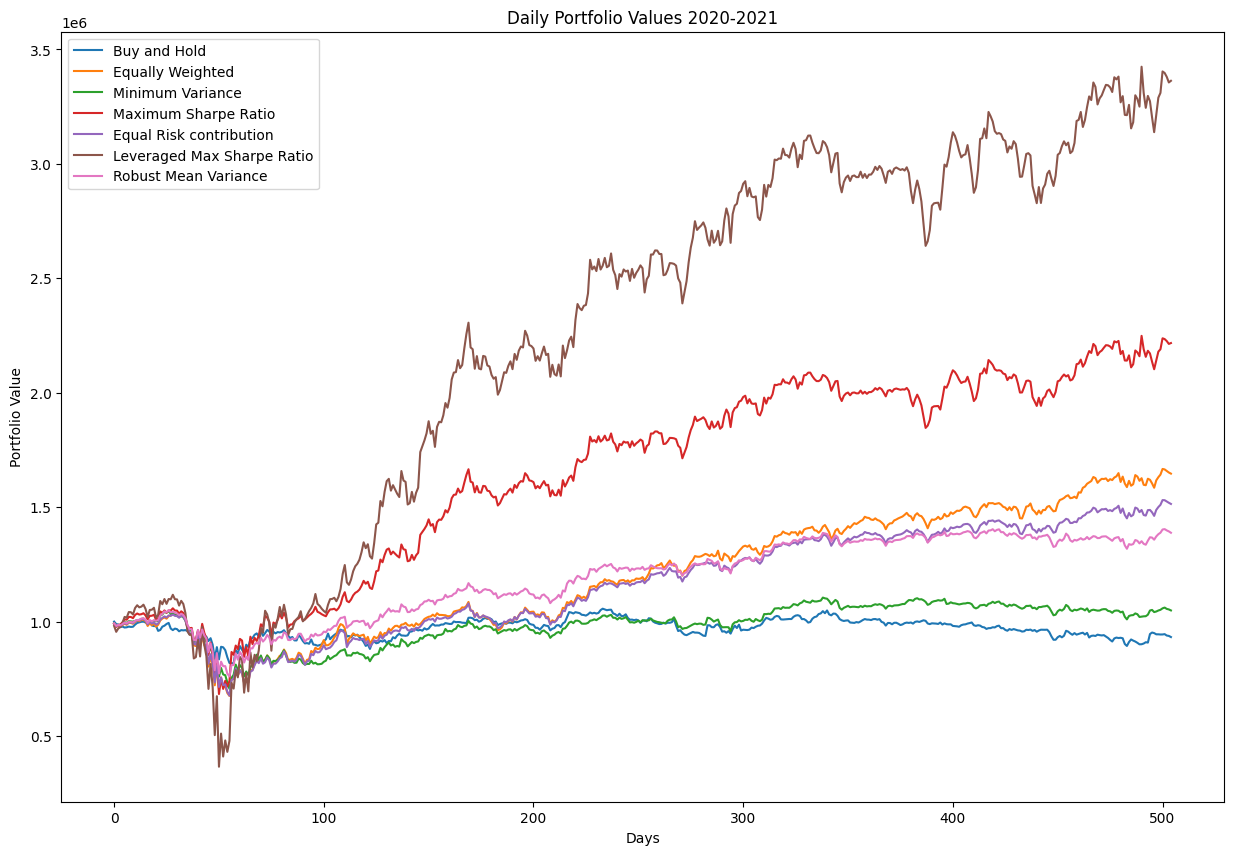

In [ ]:
sns.set_palette(sns.color_palette("tab10"))
plt.figure(figsize=(15,10))
plt.plot(portf_value[0],label='Buy and Hold')
plt.plot(portf_value[1],label='Equally Weighted')
plt.plot(portf_value[2],label='Minimum Variance')
plt.plot(portf_value[3],label='Maximum Sharpe Ratio')
plt.plot(portf_value[4],label='Equal Risk contribution')
plt.plot(portf_value[5],label='Leveraged Max Sharpe Ratio')
plt.plot(portf_value[6],label='Robust Mean Variance')
plt.legend()
plt.title('Daily Portfolio Values 2020-2021')
plt.xlabel('Days')
plt.ylabel('Portfolio Value')
plt.show()

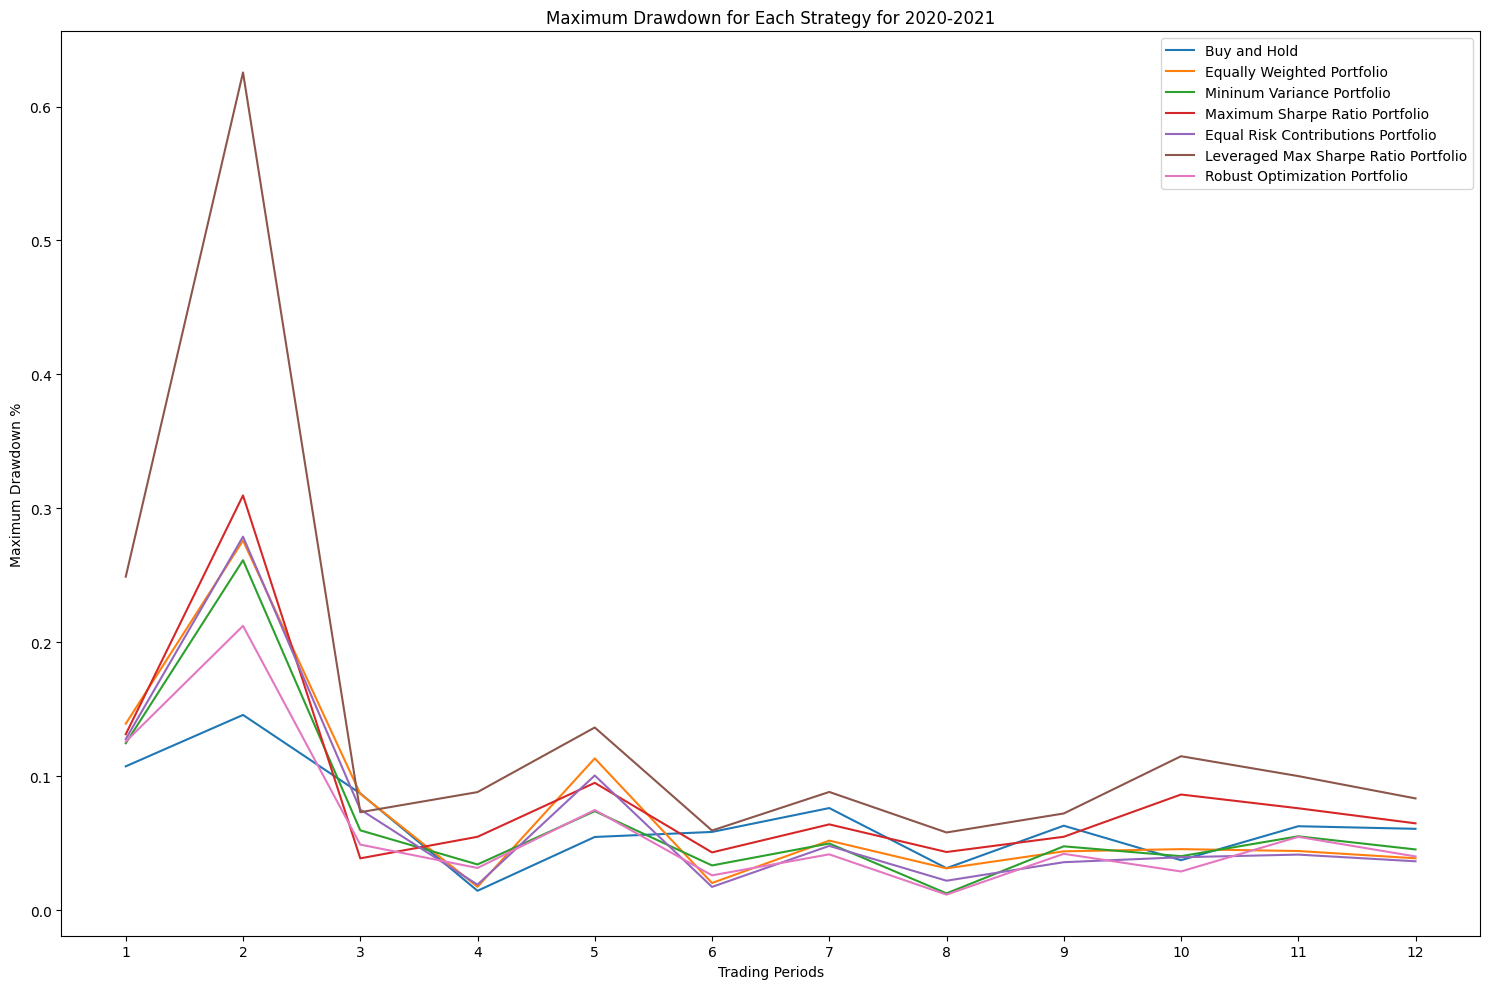

In [ ]:
def calculate_max_drawdown(portfolio_values):
    peak = np.maximum.accumulate(portfolio_values)
    drawdown = (peak - portfolio_values) / peak
    return np.max(drawdown)

max_drawdowns = np.zeros((N_strat, N_periods))
period_length = N_days // N_periods

for strategy in range(N_strat):
    for period in range(N_periods):
        # Select the portfolio values for the current period
        start_index = period * period_length
        end_index = start_index + period_length
        period_values = portf_value[strategy][start_index:end_index, 0]
        max_drawdowns[strategy, period] = calculate_max_drawdown(period_values)

plt.figure(figsize=(15, 10))
periods = np.arange(1, N_periods + 1)
for strategy in range(N_strat):
    plt.plot(periods, max_drawdowns[strategy, :], label=strategy_names[strategy])

plt.xlabel('Trading Periods')
plt.ylabel('Maximum Drawdown %')
plt.title('Maximum Drawdown for Each Strategy for 2020-2021')
plt.xticks(periods)
plt.legend()
plt.tight_layout()
plt.show()

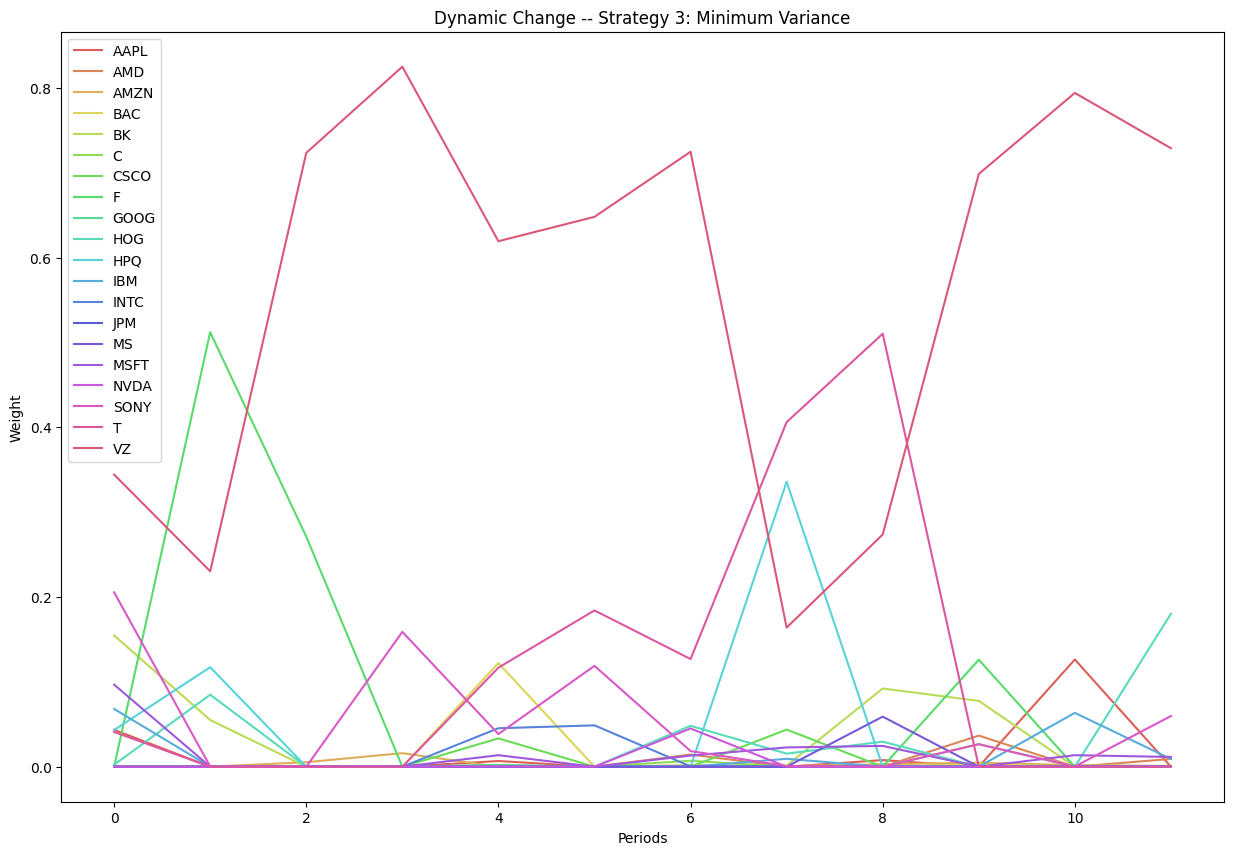

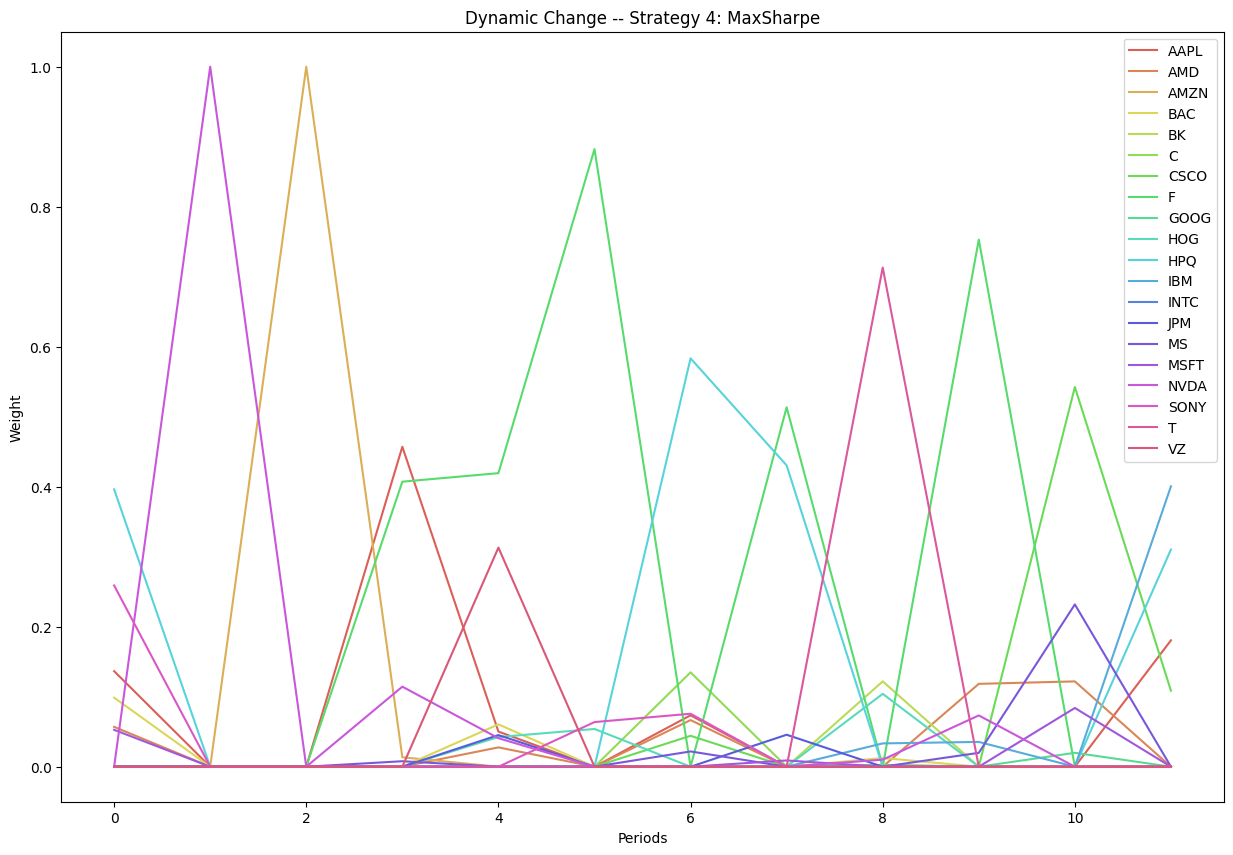

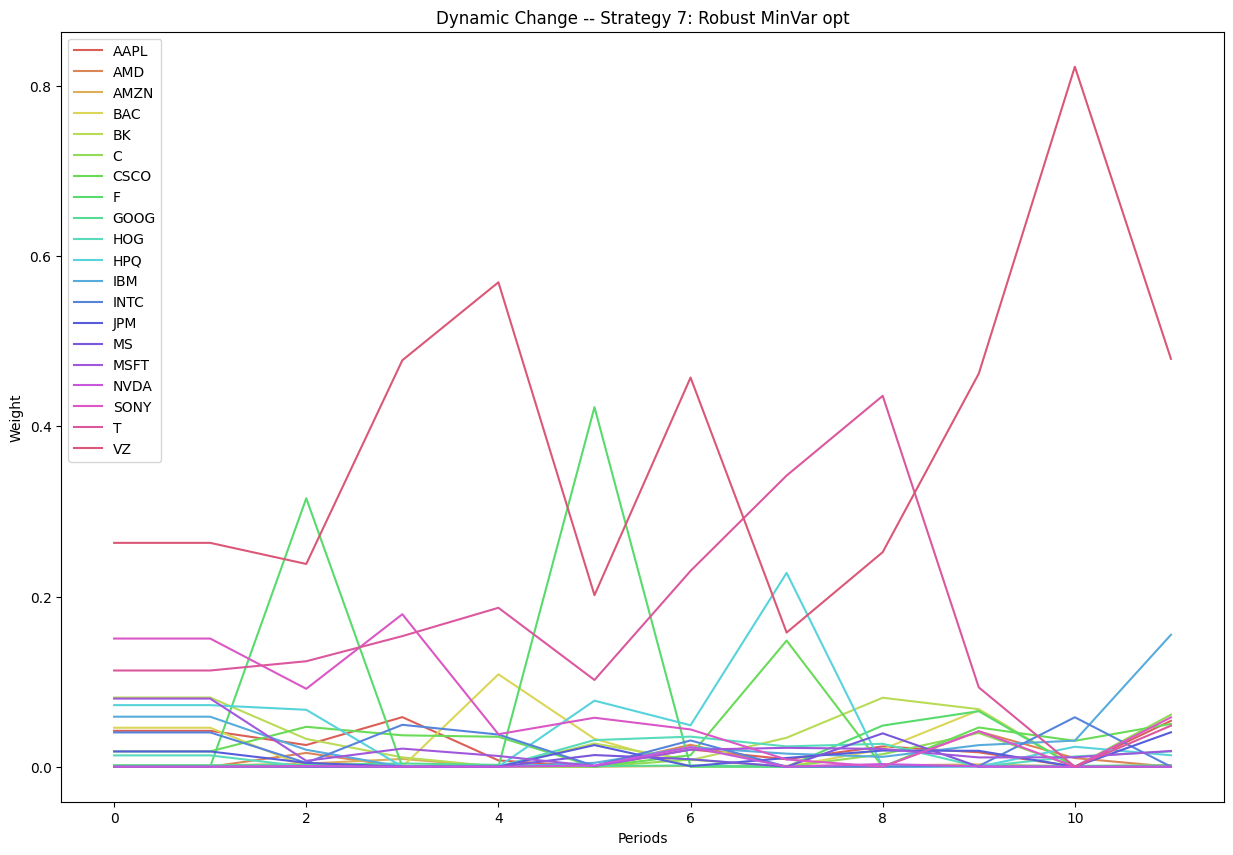

In [ ]:
# Get the column names for the stocks from the dataframe, skipping the first column
col_names = df.columns[1:]
sns.set_palette(sns.color_palette("hls", 20))

w_minvar = []
x[2, period-1], cash[2, period-1], weight[2,period-1] = fh_array[2](curr_positions, curr_cash, mu, Q, cur_prices)

for period in range(1, N_periods+1):
    w_per_period = x[2, period-1] / sum(x[2, period-1])
    w_minvar.append(w_per_period)

df_minVar = pd.DataFrame(np.array(w_minvar), columns=col_names)
df_minVar.plot(figsize=(15,10))
plt.title('Dynamic Change -- Strategy 3: Minimum Variance')
plt.xlabel('Periods')
plt.ylabel('Weight')
plt.show()

w_maxsharpe = []
x[3, period-1], cash[3, period-1],weight[2,period-1]= fh_array[3](curr_positions, curr_cash, mu, Q, cur_prices)

for period in range(1, N_periods+1):
    w_per_period = x[3, period-1] / sum(x[3, period-1])
    w_maxsharpe.append(w_per_period)

df_maxSharpe = pd.DataFrame(np.array(w_maxsharpe), columns=col_names)
df_maxSharpe.plot(figsize=(15,10))
plt.title('Dynamic Change -- Strategy 4: MaxSharpe')
plt.xlabel('Periods')
plt.ylabel('Weight')
plt.show()

w_rmv = []
x[6, period-1], cash[6, period-1],weight[6,period-1] = fh_array[6](curr_positions, curr_cash, mu, Q, cur_prices)

for period in range(1, N_periods+1):
    w_per_period = x[6, period-1] / sum(x[6, period-1])
    w_rmv.append(w_per_period)

df_rmv = pd.DataFrame(np.array(w_rmv), columns=col_names)
df_rmv.plot(figsize=(15,10))
plt.title('Dynamic Change -- Strategy 7: Robust MinVar opt')
plt.xlabel('Periods')
plt.ylabel('Weight')
plt.show()